In [1]:
baseUrl = 'http://www.tng-project.org/api/'
headers = {"api-key":"c9a75a056da4fcd072dbe6951190537d"}
import requests

def get(path, params=None):
# make HTTP GET request to path
    headers = {"api-key":"c9a75a056da4fcd072dbe6951190537d"}
    r = requests.get(path, params=params, headers=headers)

    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()

    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically

    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string

    return r

Check base simulations

In [2]:
r=get(baseUrl)
names = [sim['name'] for sim in r['simulations']]

In [4]:
names

['Illustris-1',
 'Illustris-1-Dark',
 'Illustris-2',
 'Illustris-2-Dark',
 'Illustris-3',
 'Illustris-3-Dark',
 'TNG100-1',
 'TNG100-1-Dark',
 'TNG100-2',
 'TNG100-2-Dark',
 'TNG100-3',
 'TNG100-3-Dark',
 'TNG300-3',
 'TNG300-2-Dark',
 'TNG300-2',
 'TNG300-1-Dark',
 'TNG300-1',
 'TNG300-3-Dark',
 'Illustris-1-Subbox0',
 'Illustris-1-Subbox1',
 'Illustris-1-Subbox2',
 'Illustris-1-Subbox3',
 'Illustris-2-Subbox0',
 'Illustris-2-Subbox1',
 'Illustris-2-Subbox2',
 'Illustris-2-Subbox3',
 'Illustris-3-Subbox0',
 'Illustris-3-Subbox1',
 'Illustris-3-Subbox2',
 'Illustris-3-Subbox3',
 'TNG100-1-Subbox0',
 'TNG100-1-Subbox1',
 'TNG100-2-Subbox0',
 'TNG100-2-Subbox1',
 'TNG100-3-Subbox0',
 'TNG100-3-Subbox1',
 'TNG300-3-Subbox1',
 'TNG300-3-Subbox2',
 'TNG300-3-Subbox0',
 'TNG300-2-Subbox1',
 'TNG300-2-Subbox2',
 'TNG300-2-Subbox0',
 'TNG300-1-Subbox1',
 'TNG300-1-Subbox2',
 'TNG300-1-Subbox0']

In [5]:
mass_min = 10**11.99 / 1e10 *0.704
mass_max = 10**12.01 / 1e10 *0.704

search_query = "?mass__gt=" + str(mass_min) + "&mass__lt=" + str(mass_max)

url = "http://www.tng-project.org/api/TNG100-1/snapshots/z=0/subhalos/" + search_query

subhalos = get(url)

# Number of relevant subhalos
print(subhalos['count'])



94


Find the closest subhalo to $10^{12}\,\mathrm{M}_\odot$

In [6]:
mass=[]
for i in range(subhalos['count']):
    mass.append(subhalos['results'][i]['mass_log_msun'])


In [7]:
%pylab inline
index=np.where(np.abs(np.asarray(mass)-12.)==min(np.abs(np.asarray(mass)-12.)))[0][0]

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['get']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
id = subhalos['results'][index]['id']
mass = subhalos['results'][index]['mass_log_msun']
print(id,mass)

523071 12.007329904550922


In [11]:
import h5py
import numpy as np

which_sim = 'TNG100-1'
redshift = 0.0
params = {'stars':'GFM_Metals,GFM_StellarFormationTime,GFM_InitialMass'}

scale_factor = 1.0 / (1+redshift)
little_h = 0.6774
solar_Z = 0.0127

url = "http://www.tng-project.org/api/"+str(which_sim)+"/snapshots/z=" + str(redshift) + "/subhalos/" + str(id)
print(url)


http://www.tng-project.org/api/TNG100-1/snapshots/z=0.0/subhalos/523071


In [12]:
sub = get(url) # get json response of subhalo properties
saved_filename = get(url + "/cutout.hdf5",params) # get and save HDF5 cutout file

TypeError: can only concatenate str (not "dict") to str

In [13]:
input_filename='/mnt/store1/oliverphilcox/ChempyMultiData/TNG/cutout_523071.hdf5'

In [83]:
import h5py
with h5py.File(input_filename) as f:
    all_metal_fractions = f['PartType4']['GFM_Metals'][:]
    metal_names=['H', 'He', 'C', 'N', 'O','Ne', 'Mg', 'Si', 'Fe','rest']
    star_formation_time_scale_factor= f['PartType4']['GFM_StellarFormationTime'][:]
    initial_mass = f['PartType4']['GFM_InitialMass'].value

In [84]:
# Import solar abundances
import os
%pylab inline
os.chdir('/home/oliverphilcox/ChempyMulti/')
from Chempy.solar_abundance import solar_abundances
solar=solar_abundances()
getattr(solar,'Asplund09')()#5_pure_solar')()

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [85]:
# First get correct photospheric abundances and masses
good_els = metal_names[:-1] # exclude 'rest'
el_masses=np.zeros(len(good_els))
phot_abuns=np.zeros(len(good_els))
no_fractions = np.zeros([len(all_metal_fractions),len(good_els)])
for e,el in enumerate(good_els):
    for i in range(len(solar.all_elements)):
        if solar.all_elements[i]==el:
            el_masses[e]=solar.all_element_masses[i]
            phot_abuns[e]=solar.table['photospheric'][i]
            break
        if i==len(solar.all_elements)-1:
            raise Exception('Failed to find element %s'%el)
    if el=='Fe':
        Fe_index = e
    if el=='H':
        H_index = e
    no_fractions[:,e]=all_metal_fractions[:,e]/el_masses[e] # these are unnormalized but we only consider ratios

# Now normalize by H and find [X/H] abundances:
star_abun=np.zeros_like(no_fractions)
for e in range(len(good_els)):
    star_abun[:,e] = np.log10(no_fractions[:,e]/no_fractions[:,H_index])+12.-phot_abuns[e]
    
# Now convert to [X/Fe] abuns:
for e,el in enumerate(good_els):
    if el!='Fe':
        star_abun[:,e]-=star_abun[:,Fe_index]
    else:
        pass # keep Fe/H form
    
# Now reorder to match TNG
el_names = ['C','Fe','He','Mg','N','Ne','O','Si'] # TNG elements
TNG_abun = np.zeros([len(star_abun),len(el_names)])
for e,el in enumerate(el_names):
    for m in range(len(good_els)):
        if good_els[m]==el:
            TNG_abun[:,e]=star_abun[:,m]
            break

Convert to time from scale-factor using Planck 2015 cosmology:

In [86]:
from astropy.cosmology import Planck15
star_formation_redshifts= [1./a-1. for a in star_formation_time_scale_factor]
star_formation_times = Planck15.age(np.asarray(star_formation_redshifts)).value

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['e']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


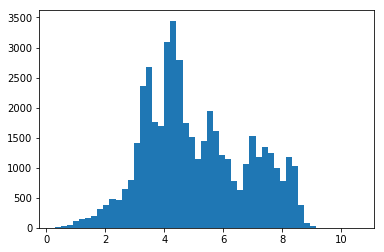

In [87]:
%pylab inline
plt.hist(star_formation_times,bins=50);

Save all data:

In [88]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/TNG_galaxy_uncut.npz',
         birth_time=star_formation_times,elements=el_names,abundance=TNG_abun)

Filter out any with $T<2$Gyr, or $T>13$Gyr to avoid errors:

In [89]:
max(star_formation_times),min(star_formation_times)

(10.594256572434647, 0.28094606208649525)

In [90]:
good_index=np.where((star_formation_times>2.)&(star_formation_times<12.8))
TNG_abuns = TNG_abun[good_index]
TNG_masses = initial_mass[good_index]
TNG_times = star_formation_times[good_index]
good_index2=np.where(np.max(np.abs(TNG_abuns),axis=1)<3.)
TNG_abuns = TNG_abuns[good_index2]
TNG_times = TNG_times[good_index2]
TNG_masses = TNG_masses[good_index2]

#### Now add in observational errors

In [91]:
ab_error = 0.05
time_error = 0.2

In [92]:
TNG_abun_err = np.ones_like(TNG_abuns)*ab_error
TNG_times_err = (TNG_times*time_error).round(2)

In [93]:
TNG_obs_abuns =np.random.normal(loc=TNG_abuns,scale=TNG_abun_err).round(2)
TNG_obs_times=np.random.normal(loc=TNG_times,scale=TNG_times_err).round(2)

First randomize these particles + remove any with bad time values:

In [94]:
jitter = np.random.choice(range(len(TNG_abuns)),replace=False,size=len(TNG_abuns))
TNG_abuns=TNG_abuns[jitter]
TNG_times=TNG_times[jitter]
TNG_masses=TNG_masses[jitter]
TNG_obs_abuns=TNG_obs_abuns[jitter]
TNG_abun_err=TNG_abun_err[jitter]
TNG_times_err=TNG_times_err[jitter]
TNG_obs_times=TNG_obs_times[jitter]

filt = np.where((TNG_obs_times>2.)&(TNG_obs_times<13.8))
TNG_abuns=TNG_abuns[filt]
TNG_times=TNG_times[filt]
TNG_masses=TNG_masses[filt]
TNG_obs_abuns=TNG_obs_abuns[filt]
TNG_abun_err=TNG_abun_err[filt]
TNG_times_err=TNG_times_err[filt]
TNG_obs_times=TNG_obs_times[filt]


Now save output:

In [95]:
np.savez('/mnt/store1/oliverphilcox/ChempyMultiData/TNG/TNG_Mock_Data_Full.npz',galaxy_index=id,
        redshift=redshift,mass=mass,elements=el_names,particle_masses=TNG_masses,
        abundances=TNG_obs_abuns,abundance_errs=TNG_abun_err,true_time=TNG_times,
        obs_time=TNG_obs_times,obs_time_err=TNG_times_err,true_abuns=TNG_abuns)

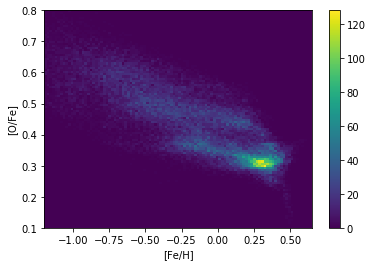

In [97]:
import matplotlib.pyplot as plt
plt.hist2d(TNG_abuns[:,1],TNG_abuns[:,6],bins=100,range=[[-1.2,0.65],[0.1,0.8]]);
plt.colorbar()
plt.ylabel('[O/Fe]')
plt.xlabel('[Fe/H]')
plt.show()